In [31]:
import numpy as np
import torch
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import spin_system, utils, particles, res_field_algorithm, constants, spectral_integration, mesher, spectra_manager
from importlib import reload
reload(mesher)
reload(spin_system)
reload(utils)
reload(particles)
reload(res_field_algorithm)
reload(spectra_manager)
reload(constants)
reload(spectral_integration)
reload(mesher)
reload(mesher.general_mesh)
reload(mesher.delanay_mesh)

<module 'mesher.delanay_mesh' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\mesher\\delanay_mesh.py'>

In [32]:
mesh = mesher.DelaunayMeshClough()

rotation_matrices = mesh.create_rotation_matrices()

In [33]:
ham_strained = torch.tensor([[1.1, 1.1, 1.3], [1.2, 1.3, 1.2]])

In [34]:
components = torch.tensor([2.1, 2.2, 2.3])
frame = torch.tensor([0, 0, 0.0])
strain = torch.tensor([0.002, 0.001, 0.002]) / 2000
components_A = torch.tensor([0.0, 0.0, 0.1])
some_interaction_1 = spin_system.Interaction(components, frame, strain)
some_interaction_2 = spin_system.Interaction(components_A, frame, strain)

In [35]:
some_interaction_1.tensor

tensor([[2.1000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 2.2000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 2.3000+0.j]])

In [36]:
electron = particles.Electron(spin=1 / 2)
g_isotropic = some_interaction_1
nucleus = particles.Nucleus("63Cu")
A = some_interaction_2
electrons = [electron]
humiltonian_strained = 3 * torch.tensor([10, 10, 10]) * (constants.PLANCK / constants.BOHR) * 1e6
nuclei = [nucleus]

In [37]:
system = spin_system.SpinSystem(electrons=electrons, nuclei=nuclei, g_tensors=[g_isotropic])

In [38]:
rotation_matrices.shape

torch.Size([192, 3, 3])

In [39]:
powder = spin_system.MultiOrientedSample(system, humiltonian_strained, rotation_matrices)

In [40]:
powder.calculate_derivative_max().shape

torch.Size([192, 1, 1])

In [41]:
resonator = res_field_algorithm.ResField()
F, Gx, Gy, Gz = powder.get_hamiltonian_terms()
resonance_frequency = torch.tensor([9.8 * 1e9])

In [42]:
B_low = torch.tensor([0.0]).expand(56)
B_high = torch.tensor([1000]).expand(56)

In [43]:
v = torch.tensor(0.0)
v.unsqueeze(-1)

tensor([0.])

In [44]:
spectra_creator = spectra_manager.SpectraCreator(8, tuple(), mesh)

In [45]:
with torch.no_grad():
    fields_1 = torch.linspace(0.29, 0.34, 2000)
    answer_1 = spectra_creator(powder, resonance_frequency, fields_1)

In [46]:
import matplotlib.pyplot as plt

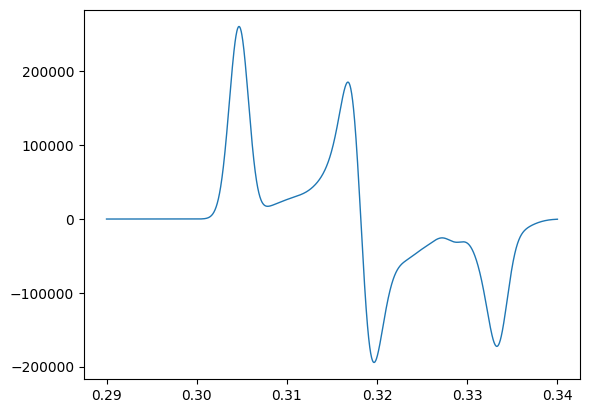

In [47]:
plt.plot(fields_1.numpy(), answer_1.numpy(),linewidth=1.0)
#plt.plot(fields_1.numpy(), answer_2.numpy(),linewidth=1.0)

In [48]:
import numpy as np
import torch
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

import mesher, spin_system, utils, particles, res_field_algorithm, spectra_manager, constants
from importlib import reload
reload(mesher)
reload(spin_system)
reload(utils)
reload(particles)
reload(res_field_algorithm)
reload(spectra_manager)
reload(constants)

<module 'constants' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\constants.py'>

In [ ]:
mesh_size = (56,)
fields = torch.linspace(0.10, 0.45, 1000)
B_low = fields[..., 0].unsqueeze(-1).expand(*mesh_size)
B_high = fields[..., -1].unsqueeze(-1).expand(*mesh_size)

In [ ]:
def print_answers():
    mesh_size = (56,)
    fields = torch.linspace(0.30, 0.33, 2000)
    B_low = fields[..., 0].unsqueeze(-1).expand(*mesh_size)
    B_high = fields[..., -1].unsqueeze(-1).expand(*mesh_size)
    F, Gx, Gy, Gz = powder.get_hamiltonian_terms()
    bathces = res_field_algorithm.ResField()(powder, resonance_frequency, B_low, B_high, F, Gz)
    (vectors_u, vectors_v), (valid_lvl_down, valid_lvl_up), B_trans, mask_trans, mask_triu, indexes, resonance_energies = bathces[0]
    
    fields = torch.linspace(0.31, 0.33, 2000)
    B_low = fields[..., 0].unsqueeze(-1).expand(*mesh_size)
    B_high = fields[..., -1].unsqueeze(-1).expand(*mesh_size)
    F, Gx, Gy, Gz = powder.get_hamiltonian_terms()
    bathces = res_field_algorithm.ResField()(powder, resonance_frequency, B_low, B_high, F, Gz)
    (vectors_u_2, vectors_v_2), (valid_lvl_down_2, valid_lvl_up_2), B_trans_2, mask_trans_2, mask_triu_2, indexes_2, resonance_energies_2 = bathces[0]

    #print(f"B_trans \n: {1 - B_trans / B_trans_2}")
    #print(f"mask_triu \n: {mask_triu}, {mask_triu_2}")
    #print(f"energies \n: {1 - resonance_energies / resonance_energies_2}")
    print(B_trans)
    #delta = (1 - ((vectors_u + 1e-22) / (vectors_u_2 + 1e-22)).abs())
    delta = (vectors_u  - vectors_u_2)
    max_u = vectors_u.abs().max(dim=(-1))[0] + vectors_u_2.abs().max(dim=(-1))[0]
    res = (delta / max_u[..., None]).abs()
    mask = (res >0.6).any(dim=(0, 2))
    print(res[:, 3, :] > 0.6)
    print(f"vectors_u \n: {delta[5, 3, :]}")
    print(f"vectors_u \n: {vectors_u_2[5, 3, :]}")
    print(f"vectors_u \n: {vectors_u[5, 3, :]}")

In [ ]:
print_answers()

In [1374]:
mesh_size = (56,)
fields = torch.linspace(0.10, 0.45, 1000)
B_low = fields[..., 0].unsqueeze(-1).expand(*mesh_size)
B_high = fields[..., -1].unsqueeze(-1).expand(*mesh_size)
print_answers(B_low, B_high)

NameError: name 'print_answers' is not defined

In [1375]:
mesh_size = (56,)
fields = torch.linspace(0.30, 0.40, 1000)
B_low = fields[..., 0].unsqueeze(-1).expand(*mesh_size)
B_high = fields[..., -1].unsqueeze(-1).expand(*mesh_size)
print_answers(B_low, B_high)

NameError: name 'print_answers' is not defined

In [1376]:
fields_1 = torch.linspace(0.305, 0.70, 2000)

In [ ]:
components = torch.tensor([2.05, 2.05, 2.3])
resonance_frequency = torch.tensor([9.8 * 1e9])
g_perp = 2.3
g_parall = 2.05
factor_1 = (1/4) * (constants.BOHR * g_perp ** 2 / (constants.PLANCK * resonance_frequency * (g_perp - g_parall))) ** 0.5
factor_2 = 1 / (fields_1 - constants.PLANCK * resonance_frequency / (g_perp * constants.BOHR )) ** 0.5

In [ ]:
answer = factor_1 * factor_2

In [ ]:
plt.plot(fields_1.numpy(), answer.numpy())

In [1565]:
post_processor = mesher.MeshProcessor(init_grid_frequency=5, interpolating_grid_frequency=6, phi_limit= 2* np.pi, interpolate=True)

In [1566]:
f_values = np.stack((post_processor.base_vertices[:, 0]**2, post_processor.base_vertices[:, 1]**2))

In [1567]:
f_values.shape

(2, 12)

In [1568]:
f_extended = post_processor.post_process(f_values)

ValueError: could not broadcast input array from shape (2,0) into shape (2,6)

In [1563]:
import numpy as np

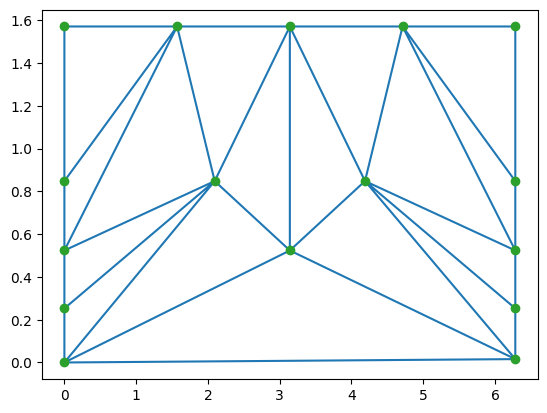

In [1564]:
tri = Delaunay(post_processor.final_vertices)
points = tri.points
import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [ ]:
points

In [1538]:
import numpy as np
from scipy.spatial import Delaunay

def _create_base_vertices(grid_frequency, phi_limit):
    """Generates base grid vertices and extended vertices up to phi_limit."""
    initial_points = np.array([[0.0, 0.01], [phi_limit/2, 1/ (grid_frequency-1)], [phi_limit, 0.01]])

    k_values = np.arange(1, grid_frequency)
    q_per_k = [np.arange(k) for k in k_values]
    q_values = np.concatenate(q_per_k)
    k_repeated = np.repeat(k_values, k_values)

    phi = phi_limit * q_values / k_repeated
    factor = k_repeated / (grid_frequency - 1)

    #theta = (np.pi / 2) * k_repeated / (grid_frequency - 1)
    theta = np.arcsin(factor)
    
    
    
    grid_points = np.column_stack((phi, theta))

    base_vertices = np.vstack((initial_points, grid_points))

    #theta_2pi = (np.pi / 2) * k_values / (grid_frequency - 1)
    theta_2pi = np.arcsin(k_values / (grid_frequency - 1))
    additional_points = np.column_stack((np.full_like(theta_2pi, phi_limit), theta_2pi))
    extended_vertices = np.vstack((base_vertices, additional_points))

    return base_vertices, extended_vertices

def spherical_to_cartesian(phi, theta, radius=1):
    """Converts spherical coordinates to Cartesian (assuming unit sphere)."""
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return np.column_stack((x, y, z))

def stereographic_projection(x, y, z):
    """Projects 3D points onto a 2D plane using stereographic projection."""
    return np.column_stack((x / (1 - z), y / (1 - z)))  # Stereographic projection

In [1539]:
_, base_vertices = _create_base_vertices(grid_frequency, 2 * np.pi)

In [ ]:
tri = Delaunay(base_vertices)
points = base_vertices
import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [1519]:
base_vertices

array([[0.        , 0.01      ],
       [6.28318531, 0.01      ],
       [0.        , 0.39269908],
       [0.        , 0.78539816],
       [3.14159265, 0.78539816],
       [0.        , 1.17809725],
       [2.0943951 , 1.17809725],
       [4.1887902 , 1.17809725],
       [0.        , 1.57079633],
       [1.57079633, 1.57079633],
       [3.14159265, 1.57079633],
       [4.71238898, 1.57079633],
       [6.28318531, 0.39269908],
       [6.28318531, 0.78539816],
       [6.28318531, 1.17809725],
       [6.28318531, 1.57079633]])

In [1508]:
grid_frequency = 5

In [1516]:
a = np.linspace(0, 1, grid_frequency)

In [1517]:
theta = np.arcsin(a)

In [1518]:
theta

array([0.        , 0.25268026, 0.52359878, 0.84806208, 1.57079633])